# Redes Neuronales
## TP1

Entrene una red de Hopfield ‘82 con las imágenes binarias disponibles en el campus.
1. Verifique si la red aprendió las imágenes enseñadas.
2. Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes aprendidas: agregado de ruido, elementos borrados o agregados.
3. Evalúe la existencia de estados espurios en la red: patrones inversos y combinaciones de un número impar de patrones. (Ver Spurious States, en la sección 2.2, Hertz, Krogh & Palmer, pág. 24).
4. Realice un entrenamiento con las 6 imágenes disponibles. ¿Es capaz la red de aprender todas las imágenes? Explique.

### Inciso 1

Lo primero que voy a hacer es importar las bibliotecas básicas para poder desarrollar el ejercicio. 

In [1]:
# primero importamos numpy y algo para leer imágenes y hacer graficos
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Para las imágenes opté la manera fácil de usarlas locales, pero no sería difícil descargarlas desde gitHub en runtime y usarlas de ahí. Para los incisos 1, 2 y 3 separé las imágenes en 2 grupos porque son de diferentes tamaños. El cuarto se hace con las 6 imágenes con alguna modificación a los tamaños. 

In [2]:
# necesito paths a las imagenes,vienen de un repo clonado localmente 
path1 = 'imagenes_tp1\\paloma.bmp'
path2 = 'imagenes_tp1\\panda.bmp' # 50*50
path3 = 'imagenes_tp1\\perro.bmp' #50*50
path4= 'imagenes_tp1\\quijote.bmp'
path5= 'imagenes_tp1\\torero.bmp'
path6= 'imagenes_tp1\\v.bmp' #50*50


Creo una función que toma una lista de paths a las imágenes y devuelve las imágenes en forma de vectores columna concatenadas. 

In [3]:
def imgPath_to_vector(paths):
    """La idea es tomar una lista de paths y generar una matriz cuyas columnas sean los pixeles de las imagenes"""
    list = []
    forma = []
    for path in paths:
        img = Image.open(path) 
        vector_img = np.array(img).astype(np.int8)
        forma.append(np.shape(vector_img)) # esto se pisa siempre pero van a ser iguales
        vector_img = vector_img.ravel()#ideal del profe, tratar las imagenes como vectores columna
        list.append(vector_img *2 -1) # acá lo ajusto para ir de (0,1)->(-1,1)
    return np.asarray(list).transpose(), list,forma

flattened_images1, lista_img1,forma1 = imgPath_to_vector([path2,path3,path6]) # tenemos las imagenes 
flattened_images2, lista_img,forma2 = imgPath_to_vector([path1,path4,path5])

La altura de estos vectores columna (nuestras "realizaciones" para el contexto de lo que buscamos que aprendan las neuonas) nos da la cantidad de neuronas y, por ende, el tamaño de la matriz $W$ de pesos de interconexión de neuronas. Como se discutió en clase, la diagonal de $W$ son ceros para que las nueronas no se realimenten a si mismas. 

Para este primer caso, el factor de aprendizaje $\eta$ se mantiene unitario, no afecta al aprendizaje. 

La matriz $W$ se compone de diferentes $w_{i,j}$, inicializados en cero (van de -1 a 1) y actualizados según la regla:
$$
\Delta {w_{i,j}}_{n} = \eta \cdot  p^1 _i \cdot p^1 _j
$$
$$
{w_{i,j} }_{n+1} = {w_{i,j}}_{n} + \Delta {w_{i,j}}_{n}
$$

Dónde $p^1 _i$ es el pattern\patrón en la iteración 1 y posición i. 

La matriz se calcula por medio de un producto matricial entre los vectores columna de datos con ellos mismos. 

In [4]:
# ahora sabemos que hay tantas neuronas como valores en los vectores columna que conforman la matriz de datos "flattened_images1"
# W es una matriz cuadrada de filas y columnas de igual tamaño a la cantidad de neuronas

def calcular_matriz_W(flattened_images,eta=1):
    filas = np.shape(flattened_images)[0] # cant de neuronas
    columnas = np.shape(flattened_images)[1] # cant de imagenes (vectores)
    W_matrix = np.zeros([filas,filas]) # creo la matriz W,de pesos

    #for i in range(columnas): # itera 1 vez por cada pattern
    #    delta_W = eta * np.asmatrix(flattened_images[:,i]).T @ np.asmatrix(flattened_images[:,i])
    #    W_matrix = W_matrix + delta_W

    delta_W = eta * np.asmatrix(flattened_images) @ np.asmatrix(flattened_images).T
    W_matrix = W_matrix + delta_W

    W_matrix = W_matrix - np.diag(np.diag(W_matrix)) # le saco la diagona,lo de diag(diag) está en lapágina de numpy
    return W_matrix

Ahora calculo la matriz de pesos para el primer set de imágenes/patrones. Con este, podemos ver la evolución de la red neuronal partiendo del patrón que se quiera. Para el primer inciso se le alimentan los mismos patrones y se revisa que no cambie entre iteraciones singulares, indicando que son mínimos en la función que representa los estados posibles de la red. En otras palabras, si no cambia es porque se aprendió el patrón. 

In [5]:
W_matrix1 = calcular_matriz_W(flattened_images1)

In [6]:
def correr_red(W, patron, iters=5):
    """Para dejar que la red vaya a algún estado desde el patron"""
    estado = patron.copy() # copia el patron como estado inicial de la red
    for _ in range(iters): # itera n veces
        estado = np.sign(W @ estado) # por ahora calcula todas juntas, aunque eso puede afectar convergencia - itera sobre los estados
    return estado

In [7]:
def chequear_aprendizaje(W_matrix,patron_inicial,original,iters=5):
    """Esta función solo recibe patrones y devuelve a donde se fue la red "iters" iteraciones despues"""
    columnas = np.shape(patron_inicial)[1] # cant de imagenes (vectores)
    lista_recordada = [] #para guardar lo que recuerda

    for i in range(columnas): # itera 1 vez por cada imagen que se aprendió
        original_i = np.asmatrix(original[:, i]).T
        patron_i = np.asmatrix(patron_inicial[:, i]).T
        res = correr_red(W_matrix,patron_i , iters)
        lista_recordada.append(res)

        if np.array_equal(original_i, res):# avisamos si las imágenes se recordaron bien o no - compara la original actual con 
            #la observada ciertas iters después
            print(f"La imagen {i} fue recordada correctamente.")
        else:
            print(f"La imagen {i} NO fue recordada correctamente.")

    return lista_recordada

In [8]:
# ahora tocaría poner la imagen real al lado de la memoria recuperada
def mostrar_resultados(memoria, imagenes,forma):
    """Función que muestra las imágenes reales arriab y a las que converge la red abajo
    
    En memoria van las resultantes de iterar, en imágenes las reales, en forma va el tamaño (np.shape()) de las imágenes. 
    """
    alto, ancho = forma[0], forma[1]
    n_imagenes = len(memoria)
    
    for i in range(n_imagenes):
        plt.subplot(2, n_imagenes, i + 1)
        plt.imshow(imagenes[:, i].reshape(alto, ancho), cmap='gray')
        plt.axis('off')
        if i == 0:  # Agregar título solo en la primera imagen
            plt.title('Imágenes originales')
        
        plt.subplot(2, n_imagenes, i + 1 + n_imagenes)
        plt.imshow(memoria[i].reshape(alto, ancho), cmap='gray')
        plt.axis('off')
        if i == 0:  # Agregar título solo en la primera imagen
            plt.title('Imágenes después de iterar')
    
    plt.tight_layout()
    plt.show()

### Resultados del inciso 1

Con todas las funciones ya definidas revisamos que las redes hayan aprendido.

In [9]:
lista_recordada1 = chequear_aprendizaje(W_matrix1,flattened_images1,flattened_images1,iters=1)

La imagen 0 fue recordada correctamente.
La imagen 1 fue recordada correctamente.
La imagen 2 fue recordada correctamente.


In [10]:
# idem con el 2do set de imagenes
W_matrix2 = calcular_matriz_W(flattened_images2)
lista_recordada2 = chequear_aprendizaje(W_matrix2, flattened_images2,flattened_images2)


La imagen 0 fue recordada correctamente.
La imagen 1 fue recordada correctamente.
La imagen 2 fue recordada correctamente.


Se observa que ambas redes entrenadas aprendieron los patrones/imágenes. Abajo se muestran comparaciones de laas imágenes reales y las aprendidas. En este caso son idénticas, pero no lo va a ser para el segundo inciso. 

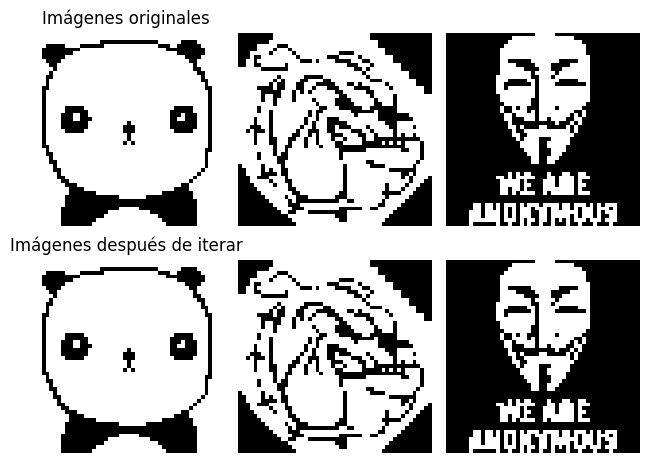

In [11]:
mostrar_resultados(lista_recordada1, flattened_images1,forma1[0])

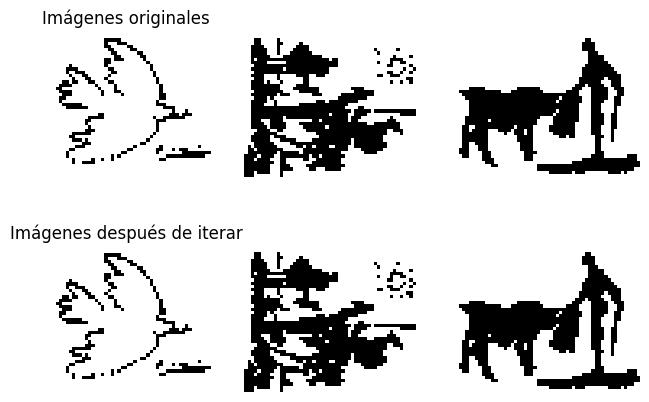

In [12]:
mostrar_resultados(lista_recordada2, flattened_images2,forma2[0])

### Inciso 2

Ahora voy a cargar unas fotos editadas a mano, con elemenos quitados y agregados. La idea es ver si la red converge a la imagen original partiendo de la editada, lo que indicaría que fueron aprendidas. Ahora incluyo las imágenes nuevas. 

In [13]:
# necesito paths a las imagenes,vienen de un repo clonado localmente 
path7 = 'imagenes_tp1\\paloma.bmp'
path8 = 'imagenes_tp1\\panda.bmp' # 50*50
path9 = 'imagenes_tp1\\perro.bmp' #50*50
path10= 'imagenes_tp1\\quijote.bmp'
path11= 'imagenes_tp1\\torero.bmp'
path12= 'imagenes_tp1\\v.bmp' #50*50

flattened_images1_editadas, lista_img1_editadas,forma1_editadas = imgPath_to_vector([path8,path9,path12]) # tenemos las imagenes 
flattened_images2_editadas, lista_img_editadas,forma2_editadas = imgPath_to_vector([path7,path10,path11])

In [14]:
def chequear_aprendizaje(W_matrix,patron_inicial,originales,iters=5):
    """Esta función solo recibe patrones y devuelve a donde se fue la red "iters" iteraciones despues"""
    columnas = np.shape(patron_inicial)[1] # cant de imagenes (vectores)
    lista_recordada = [] #para guardar lo que recuerda, una lista de estados por cada imagen

    for i in range(columnas): # itera 1 vez por cada imagen que se aprendió
        original_i = np.asmatrix(originales[:, i]).T
        patron_i = np.asmatrix(patron_inicial[:, i]).T
        proceso_reconstruccion = [] # una lista para guardar como va cambiando la red neuronal
        for n in range(iters):
            estado = correr_red(W_matrix,patron_i , iters=1) # avanzamos 1 paso
            proceso_reconstruccion.append(estado)
        lista_recordada.append(proceso_reconstruccion) # una lista de listas
        
        if np.array_equal(original_i, lista_recordada[i][iters-1]):# avisamos si las imágenes se recordaron bien o no
            print(f"La imagen {i} fue recordada correctamente.")
        else:
            print(f"La imagen {i} NO fue recordada correctamente.")

    return lista_recordada

In [15]:
lista_recordada_edit_1 = chequear_aprendizaje(W_matrix1, flattened_images1_editadas,flattened_images1)

La imagen 0 fue recordada correctamente.
La imagen 1 fue recordada correctamente.
La imagen 2 fue recordada correctamente.


In [16]:
lista_recordada_edit_2 = chequear_aprendizaje(W_matrix2, flattened_images2_editadas,flattened_images2)


La imagen 0 fue recordada correctamente.
La imagen 1 fue recordada correctamente.
La imagen 2 fue recordada correctamente.


In [20]:
def plot_reconstrucciones(originales, lista_recordada, shape):
    """
    Muestra las imágenes originales y sus reconstrucciones en grilla.

    originales: matriz (pixeles x imágenes) -> cada columna es una imagen
    lista_recordada: lista de listas devuelta por chequear_aprendizaje
    shape: tupla (alto, ancho)
    """
    num_patrones = originales.shape[1]   # ahora son columnas
    num_iters = len(lista_recordada[0])

    fig, axes = plt.subplots(num_patrones, num_iters + 1,
                             figsize=(2*(num_iters+1), 2*num_patrones))

    if num_patrones == 1:
        axes = [axes]

    for i in range(num_patrones):
        # Imagen original (columna i)
        ax = axes[i][0] if num_patrones > 1 else axes[0]
        ax.imshow(originales[:, i].reshape(shape), cmap="gray")
        ax.set_title("Original")
        ax.axis("off")

        # Iteraciones
        for j in range(num_iters):
            ax = axes[i][j+1] if num_patrones > 1 else axes[j+1]
            img_vec = np.array(lista_recordada[i][j]).ravel()
            ax.imshow(img_vec.reshape(shape), cmap="gray")
            ax.set_title(f"Iter {j+1}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()


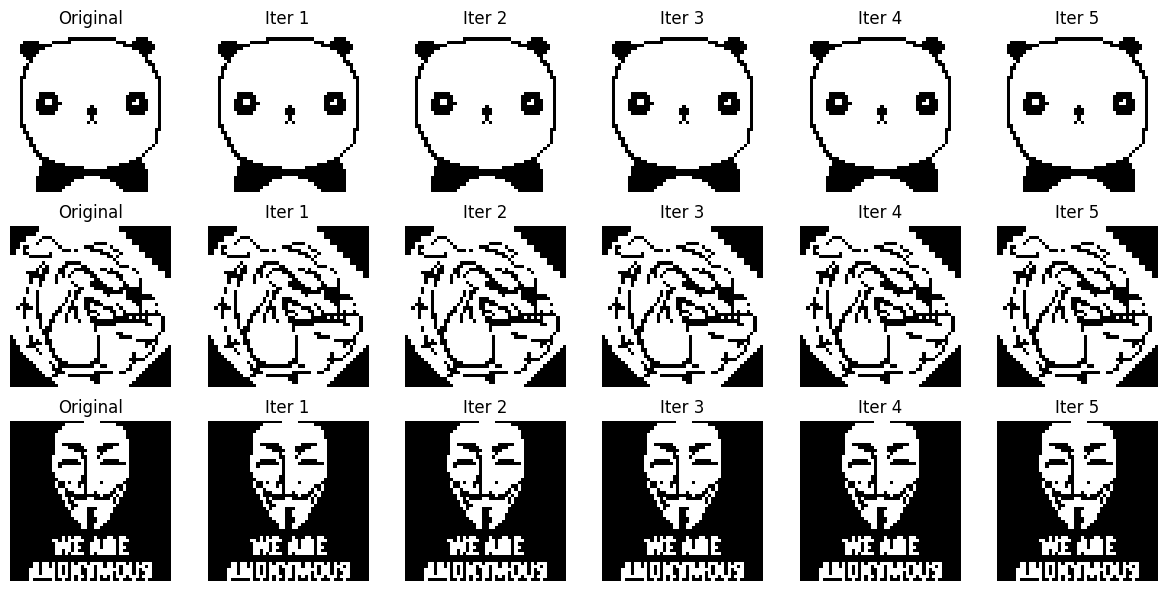

In [21]:
plot_reconstrucciones(flattened_images1_editadas, lista_recordada_edit_1, forma1[0])  # forma1 es lista, tomo [0]